<a href="https://colab.research.google.com/github/stellagerantoni/LatentCfMultivariate/blob/main/multivariate_pendigits_with_KDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/stellagerantoni/LatentCfMultivariate

Cloning into 'LatentCfMultivariate'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 92 (delta 51), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (92/92), 3.94 MiB | 7.24 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [2]:
!pip install -q wildboar
!pip install -q scikit-learn
!pip install -q stumpy
!pip install -q fastdtw


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
!pip install aeon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 19.1 MB/s eta 0:00:00


In [4]:
import logging
import os
import warnings
from argparse import ArgumentParser
from aeon.datasets import load_classification

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals
%cd '/content/LatentCfMultivariate'
from _guided import ModifiedLatentCF
from help_functions import *
from keras_models import *

/content/LatentCfMultivariate


In [5]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
RANDOM_STATE = 39

## **FUNCTIONS**

In [6]:
def load_dataset(dataset):
  X, y, meta_data = load_classification(dataset)
  if dataset == 'Heartbeat':
    pos = 'normal'
    neg = 'abnormal'
    X = X.transpose(0,2,1)
  if dataset == 'SelfRegulationSCP1':
    pos = 'positivity'
    neg = 'negativity'
    X = X.transpose(0,2,1)
  if dataset == 'Cricket':
    return X,y,meta_data
  if dataset == 'SpokenArabicDigits':
    return X,y,meta_data
  if dataset == 'PenDigits':
    return X,y,meta_data

  print(" Shape of X = ", X.shape)
  print(" Shape of y = ", y.shape)
  print(" Meta data = ", meta_data)
  # Convert positive and negative labels to 1 and 0
  pos_label, neg_label = 1, 0
  if pos != pos_label:
      y[y==pos] = pos_label # convert/normalize positive label to 1
  if neg != neg_label:
      y[y==neg] = neg_label # convert negative label to 0

  y = y.astype(int)
  print(f"\n X[:1] = \n{X[:1]}")
  return X,y,pos_label, neg_label

# **ACTUALL CODE**
datasets available : 'Heartbeat', 'SelfRegulationSCP1'

In [7]:
RANDOM_STATE = 39
X,y,data_information = load_classification('PenDigits')
print(f'shape of X = {X.shape}')
print(f'shape of y = {y.shape}')
print(f'data imformation = {data_information}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f'shape of X train = {X_train.shape}')
print(f'shape of y train = {y_train.shape}')

shape of X = (10992, 2, 8)
shape of y = (10992,)
data imformation = {'problemname': 'pendigits', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}
shape of X train = (8793, 2, 8)
shape of y train = (8793,)


In [8]:
# Upsample the minority class
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'before: {class_counts}')
X_train,y_train = upsample_minority_multivariate(X_train,y_train)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'after: {class_counts}')

before: [914 914 915 844 915 844 845 914 844 844]
after: [915 915 915 915 915 915 915 915 915 915]


In [9]:
X_train = X_train.transpose (0,2,1)
X_test = X_test.transpose(0,2,1)
n_training,n_timesteps, n_features= X_train.shape

X_train_processed, trained_scaler =  normalize_multivariate(data=X_train, n_timesteps=n_timesteps, n_features = n_features)
X_test_processed, _ =  normalize_multivariate(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler, n_features = n_features)

X_train_processed_padded, padding_size = conditional_pad_multivariate(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad_multivariate(X_test_processed)

n_timesteps_padded = X_train_processed_padded.shape[1]
print(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")

#check the processing (0,1) min should be min 0 and max should be max 1
print(f"\nmin value = {np.min(X_train)}, max value = {np.max(X_train)}")
print(f"min value normalized = {np.min(X_train_processed)}, max value normalized= {np.max(X_train_processed)}")

#check that padding paddes the right dimention
print(f"\nX_train.shape = {X_train.shape}" )
print(f"X_train_processed_padded.shape = {X_train_processed_padded.shape}")


Data pre-processed, original #timesteps=8, padded #timesteps=8.

min value = 0.0, max value = 100.0
min value normalized = 0.0, max value normalized= 1.0

X_train.shape = (9150, 8, 2)
X_train_processed_padded.shape = (9150, 8, 2)


y = 9


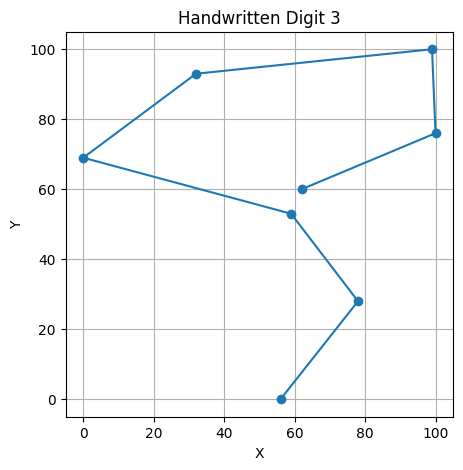

In [10]:
visualise_digit(X_train,y_train,9100)

In [11]:
X_train, y_train, X_test, y_test= extract_two_digits(X_train_processed_padded,y_train,X_test_processed_padded,y_test,'0','8',RANDOM_STATE)

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]


y = 0


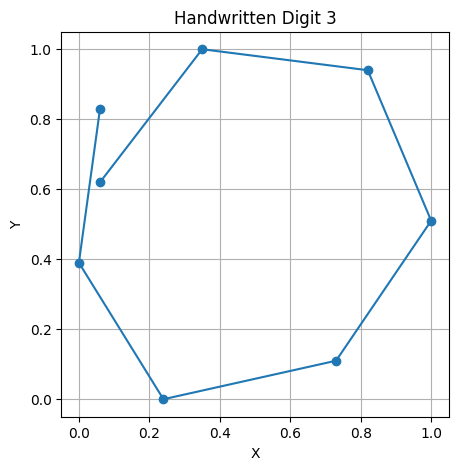

In [12]:
visualise_digit(X_train,y_train,100)

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

In [14]:
print(f'X_train = {X_train.shape}')
print(f'X_validation = {X_validation.shape}')
print(f'X_test = {X_test.shape}')

y_train_classes = y_train
y_validation_classes = y_validation
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_validation = to_categorical(y_validation, len(np.unique(y_validation)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

print(f'\ny_train_classes = {y_train_classes.shape}, y_validation_classes = {y_validation_classes.shape}, y_test_classes = {y_test_classes.shape}')
print(f'y_train = {y_train.shape}, y_validation = {y_validation.shape}, y_test= {y_test.shape}')

X_train = (1464, 8, 2)
X_validation = (366, 8, 2)
X_test = (440, 8, 2)

y_train_classes = (1464,), y_validation_classes = (366,), y_test_classes = (440,)
y_train = (1464, 2), y_validation = (366, 2), y_test= (440, 2)


y = 0


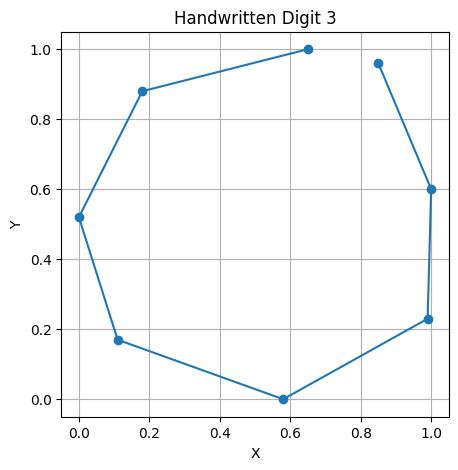

In [15]:
visualise_digit(X_train,y_train_classes,100)

In [16]:


# ## 2. LatentCF models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()
###############################################
# ### 1dCNN classifier

cnnClassifier = Classifier(
    n_timesteps_padded, n_features, n_output=2, add_dense_layer = False
)

optimizer = keras.optimizers.Adam(lr=0.001)
cnnClassifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM-FCN classifier:")
classifier_history = cnnClassifier.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=12,
    shuffle=True,
    verbose=True,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping_accuracy],
)

y_pred = cnnClassifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:8", "True:0"],
    columns=["Pred:8", "Pred:0"],
)
print(confusion_matrix_df)


Training log for LSTM-FCN classifier:
Epoch 1/150
122/122 [==============================] - 20s 17ms/step - loss: 0.2667 - accuracy: 0.9351 - val_loss: 0.5367 - val_accuracy: 0.9672
Epoch 2/150
122/122 [==============================] - 1s 8ms/step - loss: 0.1068 - accuracy: 0.9843 - val_loss: 0.3414 - val_accuracy: 0.9809
Epoch 3/150
122/122 [==============================] - 1s 6ms/step - loss: 0.0813 - accuracy: 0.9945 - val_loss: 0.1930 - val_accuracy: 0.9973
Epoch 4/150
122/122 [==============================] - 1s 6ms/step - loss: 0.0698 - accuracy: 0.9952 - val_loss: 0.0992 - val_accuracy: 0.9973
Epoch 5/150
122/122 [==============================] - 1s 6ms/step - loss: 0.0625 - accuracy: 0.9959 - val_loss: 0.0692 - val_accuracy: 0.9973
Epoch 6/150
122/122 [==============================] - 1s 6ms/step - loss: 0.0542 - accuracy: 0.9986 - val_loss: 0.0574 - val_accuracy: 0.9973
Epoch 7/150
122/122 [==============================] - 1s 5ms/step - loss: 0.0500 - accuracy: 1.0000 -

In [17]:
reset_seeds()


# ### 1dCNN autoencoder
autoencoder = Autoencoder( n_timesteps_padded,n_features,32)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=12,
    shuffle=True,
    verbose=2,
    validation_data=(X_validation, X_validation),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


(None, 8, 2)
(None, 8, 32)
(None, 4, 32)
(None, 4, 16)
(None, 2, 16)
(None, 2, 16)
(None, 4, 16)
(None, 4, 32)
(None, 8, 32)
(None, 8, 2)
Training log for 1dCNN autoencoder:
Epoch 1/50
122/122 - 3s - loss: 0.1447 - val_loss: 0.0482 - 3s/epoch - 21ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0321 - val_loss: 0.0222 - 513ms/epoch - 4ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0175 - val_loss: 0.0143 - 529ms/epoch - 4ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0123 - val_loss: 0.0104 - 531ms/epoch - 4ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0091 - val_loss: 0.0080 - 612ms/epoch - 5ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0075 - val_loss: 0.0065 - 628ms/epoch - 5ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0063 - val_loss: 0.0058 - 741ms/epoch - 6ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0055 - val_loss: 0.0050 - 682ms/epoch - 6ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0049 - val_loss: 0.0048 - 712ms/epoch - 6ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0045 - val_loss: 0.0043 - 692ms/epoch - 6ms/st

1/1 [==============================] - 0s 120ms/step
y = [[0. 1.]]


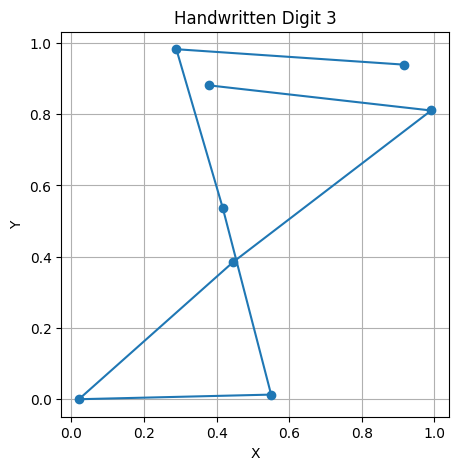

y = [0. 1.]


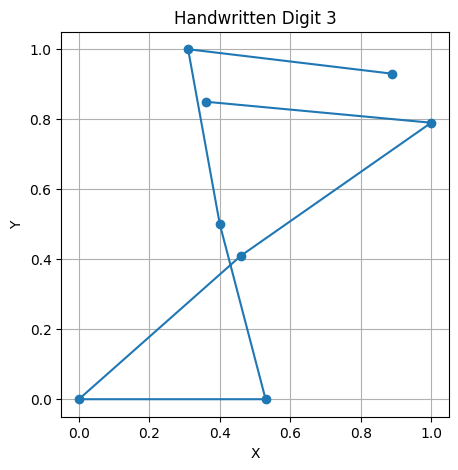

In [18]:
idx = 0
sample = X_test[idx:idx+1]
sample_label = y_test[idx:idx+1]
autoencoded_sample = autoencoder.predict(sample)
visualise_decoded_digit(autoencoded_sample,sample_label)
visualise_digit(X_test,y_test,idx)

In [19]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [1]
from help_functions import evaluate
w_type = "global"
pos_label = 1
neg_label = 0

if w_type == "global":
    step_weights = get_global_weights(
        X_train,
        y_train_classes,
        cnnClassifier,
        n_timesteps= n_timesteps,
        n_features=n_features,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )
### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    print(f"The current prediction margin weight is {pred_margin_weight}.")

    # get the negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test[y_pred_classes == neg_label][20:30]
    y_pred_neg = y_pred_classes[y_pred_classes==neg_label][10:20]
    lr_list = [0.001]


46/46 [==============================] - 0s 3ms/step
The current prediction margin weight is 1.


In [20]:
step_weights_x = step_weights[:,:,0]
step_weights_y = step_weights[:,:,1]
for idx in range(step_weights_x.shape[1]):
  if step_weights_x[:,idx] == 0:
    step_weights_x[:,idx] = 1
  elif step_weights_x[:,idx] == 1:
    step_weights_x[:,idx] = 0

for idx in range(step_weights_y.shape[1]):
  if step_weights_y[:,idx] == 0:
    step_weights_y[:,idx] = 1
  elif step_weights_y[:,idx] == 1:
    step_weights_y[:,idx] = 0


In [21]:
step_weights_x = np.transpose(step_weights_x, (1,0))
step_weights_y = np.transpose(step_weights_y, (1,0))

In [22]:
print(step_weights_x.shape)

(8, 1)


In [66]:
# @title Default title text
import warnings

import numpy as np
import tensorflow as tf
from tensorflow import keras

from wildboar.explain import IntervalImportance
#from LIMESegment.Utils.explanations import LIMESegment


class ModifiedLatentCF:
    """Explanations by generating a counterfacutal sample in the latent space of
    any autoencoder.

    References
    ----------
    Learning Time Series Counterfactuals via Latent Space Representations,
    Wang, Z., Samsten, I., Mochaourab, R., Papapetrou, P., 2021.
    in: International Conference on Discovery Science, pp. 369–384. https://doi.org/10.1007/978-3-030-88942-5_29
    """

    def __init__(
        self,
        probability=0.5,
        *,
        tolerance=1e-6,
        max_iter=100,
        optimizer=None,
        autoencoder=None,
        margin_weight=1.0,  # weighted_steps_weight = 1 - pred_margin_weight
        random_state=None,
        kde_x = None,
        kde_y = None,
        step_weights_x ,
        step_weights_y ,
        #mean of loh likelihood of all the data on x and y axis seperetly
        mean_log_likelihood_ofData_x,
        mean_log_likelihood_ofData_y
    ):
        self.optimizer_ = (
            tf.optimizers.Adam(learning_rate=1e-4) if optimizer is None else optimizer
        )
        self.mse_loss_ = keras.losses.MeanSquaredError()
        self.probability_ = tf.constant([probability])
        self.tolerance_ = tf.constant(tolerance)
        self.max_iter = max_iter
        self.autoencoder = autoencoder
        self.random_state = random_state

        # Weights of the different loss components
        self.margin_weight = margin_weight
        self.kde_weight = 1 - self.margin_weight

        #step_weights
        self.step_weights_x = step_weights_x
        self.step_weights_y = step_weights_y

        #kde related parameters
        self.kde_x = kde_x
        self.kde_y = kde_y
        self.mean_log_likelihood_ofData_x = mean_log_likelihood_ofData_x
        self.mean_log_likelihood_ofData_y = mean_log_likelihood_ofData_y

    def fit(self, model):
        """Fit a new counterfactual explainer to the model

        Paramaters
        ----------

        model : keras.Model
            The model
        """
        if self.autoencoder:
            (
                encode_input,
                encode_output,
                decode_input,
                decode_output,
            ) = extract_encoder_decoder(self.autoencoder)
            self.decoder_ = keras.Model(inputs=decode_input, outputs=decode_output)
            self.encoder_ = keras.Model(inputs=encode_input, outputs=encode_output)
        else:
            self.decoder_ = None
            self.encoder_ = None
        self.model_ = model
        return self

    def predict(self, x):
        """Compute the difference between the desired and actual probability

        Parameters
        ---------
        x : Variable
            Variable of the sample
        """
        if self.autoencoder is None:
            z = x
        else:
            z = self.decoder_(x)

        return self.model_(z)

    # The "pred_margin_loss" is designed to measure the prediction probability to the desired decision boundary
    def pred_margin_mse(self, prediction):
        return self.mse_loss_(self.probability_, prediction)

    # An auxiliary MAE loss function to measure the proximity with step_weights
    def weighted_mae(self, original_sample, cf_sample, step_weights):
        return tf.math.reduce_mean(
            tf.math.multiply(tf.math.abs(original_sample - cf_sample), step_weights)
        )

    # An auxiliary normalized L2 loss function to measure the proximity with step_weights
    def weighted_normalized_l2(self, original_sample, cf_sample, step_weights):
        var_diff = tf.math.reduce_variance(original_sample - cf_sample)
        var_orig = tf.math.reduce_variance(original_sample)
        var_cf = tf.math.reduce_variance(cf_sample)

        normalized_l2 = 0.5 * var_diff / (var_orig + var_cf)
        return tf.math.reduce_mean(
            tf.math.multiply(
                normalized_l2,
                step_weights,
            )
        )

    def train_gaussian_kde( data,use_scotts_rule=False,use_silvermans_rule=False, manual_bandwidth = None):
      """
      Train a Gaussian KDE on the provided data.

      :param data: Multivariate data points used for KDE (2D Tensor).
      :param bandwidth: The bandwidth of the kernel (float).
      :return: A function that represents the trained KDE.
      """
      n = tf.cast(tf.shape(data)[0], tf.float64)
      d = tf.cast(tf.shape(data)[1], tf.float64)

      def kde_fn( x_points):
        """
        Compute the density estimation for given points using the trained KDE.

        :param x_points: Points where the density should be estimated (2D Tensor).
        :return: Density estimates (Tensor).
        """
        d = tf.cast(tf.shape(data)[1], tf.float64)
        data_exp =  tf.expand_dims(data, axis=0)
        print(f'data dimentions = {data_exp.shape}')
        x_points_exp = tf.reshape(x_points, (tf.shape(x_points)[0], 8, 1))
        x_points_exp = tf.expand_dims(x_points_exp, axis=1)
        print(f'x_points dimentions = {x_points_exp.shape}')

        if use_scotts_rule:
          sigma = tf.math.reduce_std(data)
          bandwidth = n ** (-1.0 / (d + 4)) * sigma
        elif use_silvermans_rule:
          sigma = tf.math.reduce_std(data)
          bandwidth = (4 * sigma**5 / (3 * n)) ** (1/5)
        else:
          if manual_bandwidth is None:
            raise ValueError("Manual bandwidth must be provided if not using Scott's Rule.")
          bandwidth = manual_bandwidth

        bandwidth = tf.cast(bandwidth, dtype=tf.float64)
        print(x_points_exp.dtype, data_exp.dtype)
        diff = x_points_exp - data_exp
        norm = tf.reduce_sum(diff ** 2, axis=2)
        kernel_val = tf.exp(-norm / (2.0 * bandwidth ** 2))


        d = tf.constant(d,tf.float64)
        density = tf.reduce_mean(kernel_val, axis=1) / (bandwidth * tf.sqrt(2.0 * np.pi * d))
        return density

      return kde_fn

    def gaussian_kde_logpdf(self, kde_fn, x_points):
      """
      Evaluate the logpdf of the given points using the trained KDE function.

      :param kde_fn: Trained KDE function.
      :param x_points: Points to evaluate the logpdf (2D Tensor).
      :return: Log of the density estimates (Tensor).
      """
      density = kde_fn(x_points)
      return tf.math.log(density)


    # additional input of step_weights
    def compute_loss(self,original_sample, z_search, target_label):
        loss = tf.zeros(shape=())
        decoded = self.decoder_(z_search) if self.autoencoder is not None else z_search
        pred = self.model_(decoded)[:, target_label]

        #margin loss (y-τ)
        margin_loss = self.pred_margin_mse(pred)
        loss += self.margin_weight * margin_loss

        #The likelihood of the distribution beeing neer to the mean of the distributions of the known data (mean.likelihood(d) - likelihood(sample))
        decoded_x =  decoded [:,:,0:1]
        decoded_y =  decoded [:,:,1:2]
        log_likelihood_ofSample_x = float(self.gaussian_kde_logpdf(self.kde_x, x_points = (decoded_x*self.step_weights_x)))
        log_likelihood_ofSample_y = float(self.gaussian_kde_logpdf(self.kde_y, x_points = (decoded_y*self.step_weights_y)))
        kde_loss = (self.mean_log_likelihood_ofData_x - log_likelihood_ofSample_x) +  ((self.mean_log_likelihood_ofData_y - log_likelihood_ofSample_y))
        loss +=self.kde_weight *kde_loss


        return loss, margin_loss, kde_loss

    # TODO: compatible with the counterfactuals of wildboar
    #       i.e., define the desired output target per label


    def transform(self, x, pred_labels):
        """Generate counterfactual explanations

        x : array-like of shape [n_samples, n_timestep, n_dims]
            The samples
        """

        result_samples = np.empty(x.shape)
        losses = np.empty(x.shape[0])
        # `weights_all` needed for debugging
        weights_all = np.empty((x.shape[0], 1, x.shape[1], x.shape[2]))

        for i in range(x.shape[0]):
            print(f"sample {i+1} is beeing transformed.")

            x_sample, loss = self._transform_sample(
                x[np.newaxis, i], self.step_weights_x, self.step_weights_y, pred_labels[i]
            )

            result_samples[i] = x_sample
            losses[i] = loss
            weights_all[i] = step_weights

        print(f"{i+1} samples been transformed, in total.")

        return result_samples, losses, weights_all

    def _transform_sample(self, x, step_weights_x, step_weights_y, pred_label):
        """Generate counterfactual explanations(z))"""
        # TODO: check_is_fitted(self)
        if self.autoencoder is not None:
            z = tf.Variable(self.encoder_(x))
        else:
            z = tf.Variable(x, dtype=tf.float32)

        it = 0
        target_label = 1 - pred_label  # for binary classification

        #def compute_loss(self,original_sample, z_search, target_label)
        with tf.GradientTape(persistent=True) as tape:
            loss, pred_margin_loss, weighted_steps_loss = self.compute_loss(
                x, z,  target_label
            )
        if self.autoencoder is not None:
            pred = self.model_(self.decoder_(z))
        else:
            pred = self.model_(z)

        # # uncomment for debug
        # print(
        #     f"current loss: {loss}, pred_margin_loss: {pred_margin_loss}, weighted_steps_loss: {weighted_steps_loss}, pred prob:{pred}, iter: {it}."
        # )

        # TODO: modify the loss to check both validity and proximity; how to design the condition here?
        # while (pred_margin_loss > self.tolerance_ or pred[:, 1] < self.probability_ or weighted_steps_loss > self.step_tolerance_)?
        # loss > tf.multiply(self.tolerance_rate_, loss_original)


        while (
            (pred_margin_loss > self.tolerance_
            or pred[:, target_label] < self.probability_)
            and (it < self.max_iter if self.max_iter else True)
            ) :
            # Get gradients of loss wrt the sample
            grads = tape.gradient(loss, z)
            # Update the weights of the sample
            self.optimizer_.apply_gradients([(grads, z)])
            del tape
            #self,original_sample, z_search, target_label
            with tf.GradientTape(persistent=True) as tape:
                loss, pred_margin_loss, kde_loss = self.compute_loss(
                    x, z,  target_label
                )

            kde_loss = tf.convert_to_tensor(kde_loss, dtype=tf.float32)
            grads = tape.gradient(loss, z)
            # Optionally, compute and log gradients for individual components
            kde_grads = tape.gradient(kde_loss, z)
            margin_grads = tape.gradient(pred_margin_loss, z)


            it += 1
            if it % 50 == 0:
              print(f'kde loss at iteration {it}: {kde_loss}')
              if kde_grads is not None:
                print(f'KDE Gradients at iteration {it}: Mean: {tf.reduce_mean(kde_grads).numpy()}, Max: {tf.reduce_max(kde_grads).numpy()}, Min: {tf.reduce_min(kde_grads).numpy()}')
              else:
                print("KDE Gradients are None.")
              print(f'Currently on iteration: {it}.')
            if self.autoencoder is not None:
                pred = self.model_(self.decoder_(z))
            else:
                pred = self.model_(z)

        # # uncomment for debug
        # print(
        #     f"current loss: {loss}, pred_margin_loss: {pred_margin_loss}, weighted_steps_loss: {weighted_steps_loss}, pred prob:{pred}, iter: {it}. \n"
        # )

        res = z.numpy() if self.autoencoder is None else self.decoder_(z).numpy()
        return res, float(loss)


def extract_encoder_decoder(autoencoder):
    """Extract the encoder and decoder from an autoencoder

    autoencoder : keras.Model
        The autoencoder of `k` encoders and `k` decoders
    """
    depth = len(autoencoder.layers) // 2
    encoder = autoencoder.layers[1](autoencoder.input)
    for i in range(2, depth):
        encoder = autoencoder.layers[i](encoder)

    encode_input = keras.Input(shape=encoder.shape[1:])
    decoder = autoencoder.layers[depth](encode_input)
    for i in range(depth + 1, len(autoencoder.layers)):
        decoder = autoencoder.layers[i](decoder)

    return autoencoder.input, encoder, encode_input, decoder

In [24]:
step_weights_x

array([[0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.]])

In [25]:
print((X_train[:, :, :1]).shape)

(1464, 8, 1)


In [ ]:
print(X_train[:, :, :1])

In [27]:
print((X_train[:, :, :1]*step_weights_x).shape)

(1464, 8, 1)


In [28]:
X_train[:, :, :1].shape

(1464, 8, 1)

In [29]:
X_train[y_train_classes == 1][:,:,0].shape

(732, 8)

In [30]:
print(X_train[:, :, :1]*step_weights_x)
print(X_train[y_train_classes == 1][:,:,0]*step_weights_x)

[[[0.  ]
  [0.  ]
  [0.36]
  ...
  [0.48]
  [0.  ]
  [0.  ]]

 [[0.  ]
  [0.  ]
  [0.24]
  ...
  [0.82]
  [0.  ]
  [0.  ]]

 [[0.  ]
  [0.  ]
  [0.7 ]
  ...
  [0.65]
  [0.  ]
  [0.  ]]

 ...

 [[0.  ]
  [0.  ]
  [0.  ]
  ...
  [1.  ]
  [0.  ]
  [0.  ]]

 [[0.  ]
  [0.  ]
  [1.  ]
  ...
  [0.02]
  [0.  ]
  [0.  ]]

 [[0.  ]
  [0.  ]
  [0.47]
  ...
  [0.42]
  [0.  ]
  [0.  ]]]


ValueError: ignored

In [ ]:
X_train[y_train_classes == 1][:,:,0]*step_weights_x

In [ ]:
X_train[y_train_classes == 1]

In [ ]:
step_weights_y

In [53]:
x_axis_eights = X_train[y_train_classes == 1][:,:,0]
y_axis_eights = X_train[y_train_classes == 1][:,:,1]
x_axis_eights = x_axis_eights[:,:,np.newaxis]
y_axis_eights = y_axis_eights[:,:,np.newaxis]

kde_x = train_gaussian_kde(x_axis_eights*step_weights_x,use_scotts_rule=False,use_silvermans_rule=True,manual_bandwidth = 0.1)
kde_y = train_gaussian_kde(y_axis_eights*step_weights_y,use_scotts_rule=False,use_silvermans_rule=False,manual_bandwidth = 0.1)

In [ ]:
#what shape the train and test samples should have
print (f'step_weights = {step_weights_x.shape}')
x_axis_eights.shape

In [ ]:
X_test[y_test_classes == 1][:1, :, :]

In [ ]:
X_test[y_test_classes == 1][:1, :, 1]

In [ ]:
X_test[y_test_classes == 1][:1, :, 0]

In [ ]:
print(gaussian_kde_logpdf(kde_y,X_test[y_test_classes == 1][:15, :, 1:2]*step_weights_y))
print(np.mean(gaussian_kde_logpdf(kde_y,X_test[y_test_classes == 1][:, :, 1:2]*step_weights_y)))

In [ ]:
print(gaussian_kde_logpdf(kde_y,X_test[y_test_classes == 0][:15, :, 1:2]*step_weights_y))
print(np.mean(gaussian_kde_logpdf(kde_y,X_test[y_test_classes == 0][:, :, 1:2]*step_weights_y)))

In [ ]:
print(gaussian_kde_logpdf(kde_x,X_test[y_test_classes == 1][:15, :, :1]*step_weights_x))
print(np.mean(gaussian_kde_logpdf(kde_x,X_test[y_test_classes == 1][:, :, :1]*step_weights_x)))

In [ ]:
print(gaussian_kde_logpdf(kde_x,X_test[y_test_classes == 0][:15, :, :1]*step_weights_x))
print(np.mean(gaussian_kde_logpdf(kde_x,X_test[y_test_classes == 0][:, :, :1]*step_weights_x)))

In [68]:
def train_gaussian_kde(data,use_scotts_rule=False,use_silvermans_rule=False, manual_bandwidth = None):
    """
    Train a Gaussian KDE on the provided data.

    :param data: Multivariate data points used for KDE (2D Tensor).
    :param bandwidth: The bandwidth of the kernel (float).
    :return: A function that represents the trained KDE.
    """
    n = tf.cast(tf.shape(data)[0], tf.float64)
    d = tf.cast(tf.shape(data)[1], tf.float64)

    def kde_fn(x_points):
        """
        Compute the density estimation for given points using the trained KDE.

        :param x_points: Points where the density should be estimated (2D Tensor).
        :return: Density estimates (Tensor).
        """
        d = tf.cast(tf.shape(data)[1], tf.float64)
        data_exp =  tf.expand_dims(data, axis=0)
        # print("1")
        # print(x_points.shape)
        x_points_exp = tf.reshape(x_points, (tf.shape(x_points)[0], 8, 1))
        # print("2")
        # print(x_points_exp.shape)
        x_points_exp = tf.expand_dims(x_points_exp, axis=1)
        # print("3")
        # print(x_points_exp.shape)


        if use_scotts_rule:
          sigma = tf.math.reduce_std(data)
          bandwidth = n ** (-1.0 / (d + 4)) * sigma
        elif use_silvermans_rule:
          sigma = tf.math.reduce_std(data)
          bandwidth = (4 * sigma**5 / (3 * n)) ** (1/5)
        else:
          if manual_bandwidth is None:
            raise ValueError("Manual bandwidth must be provided if not using Scott's Rule.")
          bandwidth = manual_bandwidth
        bandwidth = tf.cast(bandwidth, dtype=tf.float64)
        x_points_exp = tf.cast(x_points_exp, dtype=tf.float64)
        # print(x_points_exp.dtype, data_exp.dtype)
        diff = x_points_exp - data_exp
        norm = tf.reduce_sum(diff ** 2, axis=2)
        kernel_val = tf.exp(-norm / (2.0 * bandwidth ** 2))


        d = tf.constant(d,tf.float64)
        density = tf.reduce_mean(kernel_val, axis=1) / (bandwidth * tf.sqrt(2.0 * np.pi * d))
        return density

    return kde_fn

def gaussian_kde_logpdf(kde_fn, x_points):
    """
    Evaluate the logpdf of the given points using the trained KDE function.

    :param kde_fn: Trained KDE function.
    :param x_points: Points to evaluate the logpdf (2D Tensor).
    :return: Log of the density estimates (Tensor).
    """
    density = kde_fn(x_points)
    return tf.math.log(density)

In [ ]:
data_exp_eights = tf.expand_dims(X_train[y_train_classes == 1][:2, :, :1], 0)
x_points_exp_eights = x_points_exp = tf.expand_dims(X_test[y_test_classes==1][0:1], 1)
x_points_exp_zeroes = x_points_exp = tf.expand_dims(X_test[y_test_classes==0][0:2], 1)
bandwidth = 0.5

In [ ]:
data_exp_eights

In [ ]:
data_exp_eights

In [ ]:
x_points_exp_eights

In [ ]:
diff = x_points_exp_eights - data_exp_eights
norm = tf.reduce_sum(diff ** 2, axis=2)
kernel_val = tf.exp(-norm / (2.0 * bandwidth ** 2))

In [ ]:
diff

In [ ]:
norm

In [ ]:
max_log_likelihood = np.max(kde_1.logpdf(X_train[y_train_classes == 1][:,:,0].T))
min_log_likelihood = np.min(kde_1.logpdf(X_train[y_train_classes == 1][:,:,0].T))
print(f'Max log_likelihood = {max_log_likelihood}')
print(f'Min log_likelihood = {min_log_likelihood}')

In [69]:
x_axis_eights = X_train[y_train_classes == 1][:,:,0]
y_axis_eights = X_train[y_train_classes == 1][:,:,1]
x_axis_eights = x_axis_eights[:,:,np.newaxis]
y_axis_eights = y_axis_eights[:,:,np.newaxis]

kde_x = train_gaussian_kde(x_axis_eights*step_weights_x,use_scotts_rule=False,use_silvermans_rule=True,manual_bandwidth = 0.1)
kde_y = train_gaussian_kde(y_axis_eights*step_weights_y,use_scotts_rule=False,use_silvermans_rule=False,manual_bandwidth = 0.1)

In [70]:
reset_seeds()
cf_model = ModifiedLatentCF(
    probability=0.9,tolerance=1e-6, max_iter=100, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),autoencoder = autoencoder,
    margin_weight=0.75, step_weights_x = step_weights_x, step_weights_y = step_weights_y, random_state= RANDOM_STATE,kde_x = kde_x, kde_y = kde_y,
    mean_log_likelihood_ofData_x = np.mean(gaussian_kde_logpdf(kde_x,X_test[y_test_classes == 1][:, :, :1]*step_weights_x)),
    mean_log_likelihood_ofData_y = np.mean(gaussian_kde_logpdf(kde_y,X_test[y_test_classes == 1][:, :, 1:2]*step_weights_y))
    )
cf_model.fit(cnnClassifier)

y_neg = y_train_classes[y_train_classes == 0][10:12]
X_neg = X_train[y_train_classes == 0][10:12]

# def transform(self, x, pred_labels)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning) # ignore warning of matrix multiplication: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice
    cf_embeddings, losses, weights = cf_model.transform(x = X_neg,pred_labels = y_neg) #self, x, pred_label
z_pred = cnnClassifier.predict(cf_embeddings)[:, 1] # predicted probabilities of CFs

#evaluate_res = evaluate(X_pred_neg, best_cf_samples, z_pred, n_timesteps, tree, max_distance)
#evaluate_res #  proximity, validity, cost_mean, cost_std

#print(f'Transformation_finished with validity_score = {validity_score(y_neg_classes,cf_pred_labels)}')

sample 1 is beeing transformed.
kde loss at iteration 50: 1.9918794631958008
KDE Gradients are None.
Currently on iteration: 50.
kde loss at iteration 100: 4.362738609313965
KDE Gradients are None.
Currently on iteration: 100.
sample 2 is beeing transformed.
kde loss at iteration 50: 8.512150764465332
KDE Gradients are None.
Currently on iteration: 50.
kde loss at iteration 100: 12.268051147460938
KDE Gradients are None.
Currently on iteration: 100.
2 samples been transformed, in total.
1/1 [==============================] - 0s 52ms/step


actual
y = 0


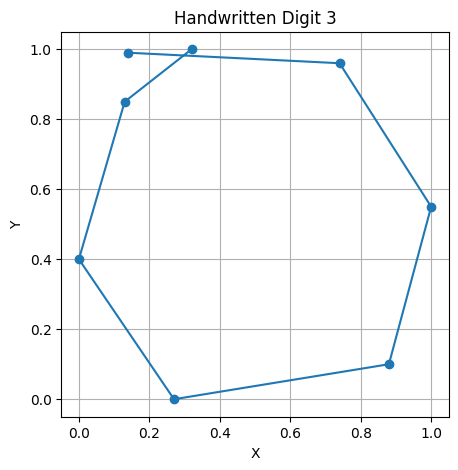

counterfactual
y = 0


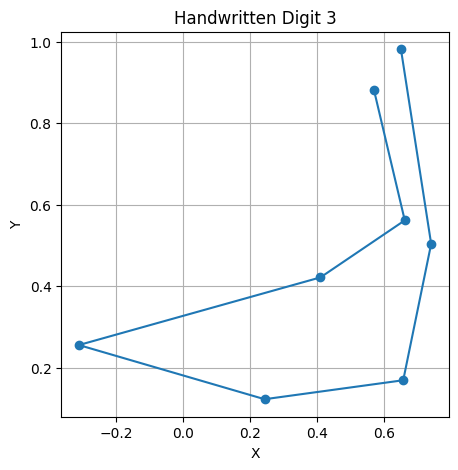

actual
y = 0


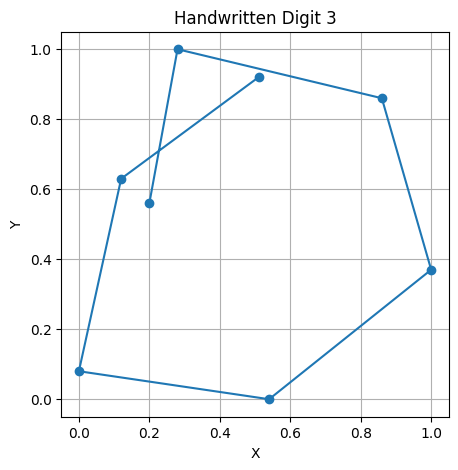

counterfactual
y = 0


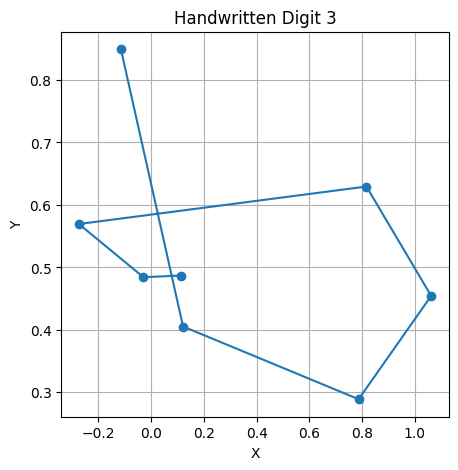

actual
y = 0


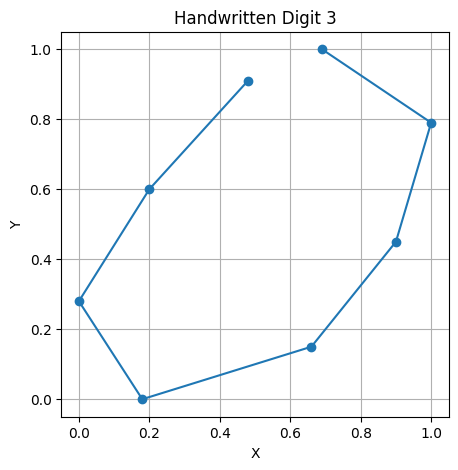

counterfactual


IndexError: ignored

In [71]:
#with learning rate = 0.001 and 500 iterations (and 1000)
for i in range(5):
  print("actual")
  visualise_digit(X_pred_neg,y_pred_neg,i,figsize = (5,5))
  print("counterfactual")
  visualise_digit(cf_embeddings,y_neg,i,figsize = (5,5))


In [ ]:
#with learning rate = 0.001 and 2000 iterations
for i in range(6):
  print("actual")
  visualise_digit(X_pred_neg,y_pred_neg,i-1,figsize = (5,5))
  print("counterfactual")
  visualise_digit(cf_embeddings,y_neg,i-1,figsize = (5,5))

In [ ]:
#with learning rate = 0.0001 and 500 iterations
for i in range(6):
  print("actual")
  visualise_digit(X_pred_neg,y_pred_neg,i-1,figsize = (5,5))
  print("counterfactual")
  visualise_digit(cf_embeddings,y_neg,i-1,figsize = (5,5))